In [14]:
import pandas as pd

# Try reading with ISO-8859-1 encoding
df = pd.read_csv('/content/data.csv', encoding='ISO-8859-1')

# Preview the data
df.head()



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
# Remove rows with missing customer ID or bad data
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

In [15]:
# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [16]:
# Convert dates
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [17]:
import numpy as np

# Set a reference date (like the most recent date in the dataset)
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [18]:
# Group by customer
ltv_data = df.groupby('CustomerID').agg({
    'InvoiceDate': [lambda x: (ref_date - x.max()).days,  # Recency
                    'count'],                              # Frequency
    'TotalPrice': ['sum', 'mean']                          # Monetary Value
})

ltv_data.columns = ['recency_days', 'frequency', 'total_value', 'avg_order_value']
ltv_data.reset_index(inplace=True)

In [19]:
# Set total_value as the proxy for LTV
ltv_data['ltv'] = ltv_data['total_value']

ltv_data.head()

,CustomerID,recency_days,frequency,total_value,avg_order_value,ltv
0,12346.0,178,2,0.00,0.000000,0.00
1,12347.0,35,102,2205.95,21.626961,2205.95
2,12348.0,101,28,1487.24,53.115714,1487.24
3,12350.0,162,17,334.40,19.670588,334.40
4,12352.0,114,48,601.18,12.524583,601.18


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

In [ ]:
# Features and target
X = ltv_data[['recency_days', 'frequency', 'avg_order_value']]
y = ltv_data['ltv']

In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Train model
model = XGBRegressor()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

In [ ]:
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 526.97
RMSE: 4162.32


In [ ]:
# Predict LTV for all
ltv_data['predicted_ltv'] = model.predict(X)


In [ ]:
# Segment by predicted LTV
ltv_data['segment'] = pd.qcut(ltv_data['predicted_ltv'], q=4, labels=['Low', 'Mid', 'High', 'VIP'])

ltv_data[['CustomerID', 'predicted_ltv', 'segment']].head()

,CustomerID,predicted_ltv,segment
0,12346.0,76913.414062,VIP
1,12347.0,4283.449219,VIP
2,12348.0,1705.676392,VIP
3,12349.0,1757.314575,VIP
4,12350.0,351.227448,Mid


In [20]:
# Save predictions
ltv_data[['CustomerID', 'predicted_ltv', 'segment']].to_csv('ltv_predictions.csv', index=False)



KeyError: "['predicted_ltv', 'segment'] not in index"

In [23]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# 1. Select Features and Target
X = ltv_data[['recency_days', 'frequency', 'avg_order_value']]
y = ltv_data['ltv']

# 2. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train Model
model = XGBRegressor()
model.fit(X_train, y_train)

# 4. Predict LTV
ltv_data['predicted_ltv'] = model.predict(X)

# 5. Segment Customers based on predicted LTV
ltv_data['segment'] = pd.qcut(ltv_data['predicted_ltv'], q=4, labels=['Low', 'Mid', 'High', 'VIP'])


In [24]:
# Save the final CSV
ltv_data[['CustomerID', 'predicted_ltv', 'segment']].to_csv('ltv_predictions.csv', index=False)


In [25]:
import joblib
joblib.dump(model, 'ltv_model.pkl')


['ltv_model.pkl']

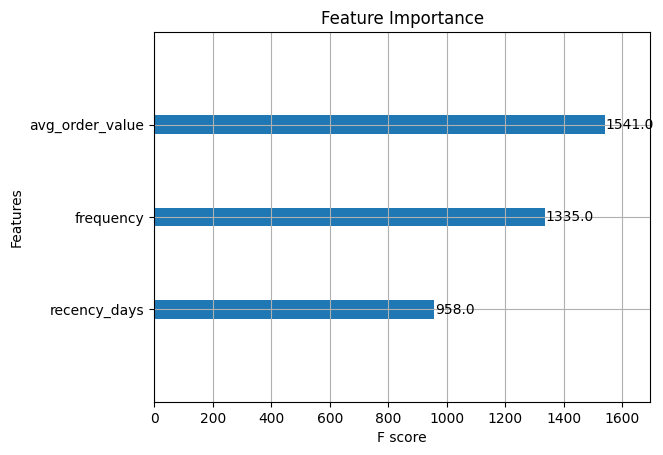

In [26]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(model)
plt.title('Feature Importance')
plt.show()


In [27]:
from google.colab import files
files.download('ltv_predictions.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>